In [1]:
import numpy
import scipy
import matplotlib.pyplot as plt

# Advanced Least Squares

In 7.1, we saw the simplest and classic method of solving for a straight best fit line for some data corrupted by noise. We introduced the matrix representation of the least squares solver as the quickest and easiest method to approximately solve for these coefficients. 

In this notebook we will break down the mathematics of this approach more clearly, including a deep dive into the linear algebra and solving step required. 

We will use a slightly more elaborate model example to help move things along. In our first example in 7.1, we saw how to solve a straight best-fit line: $y= mx + c$, which is essentially a first order polynomial expansion. We can also use a $N$-th order expansion:

$y = c + m_1x + m_2x^2 + \dots mx^N + \epsilon$

where $m_1$,$m_2$ correspond to our polynomial coefficients, and $x$ is our data. For now, we'll settle with a second order polynomial expansion:

$y = c + m_1x + m_2x^2 + \epsilon $

In [2]:
def generate_data(m1,m2,c,N,sigma):
    xvec = numpy.arange(0,10,10/N)
    noisevec = numpy.random.normal(0.0,sigma,size=N)
    return xvec,(c + m1*xvec + m2 * xvec**2 + noisevec)

In [3]:
xvec, data = generate_data(0.2,0.4,20.0,300,5.0)

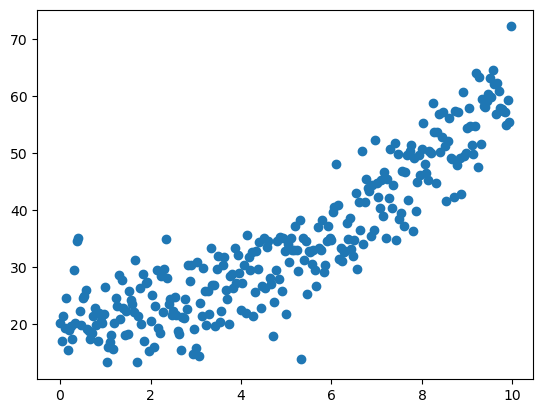

In [4]:
plt.scatter(xvec,data)
plt.show()

In [5]:
print(xvec[:,numpy.newaxis].shape)

(300, 1)


In [6]:
A = numpy.concatenate((xvec[:,numpy.newaxis],xvec[:,numpy.newaxis]**2,numpy.ones(xvec.shape[0])[:,numpy.newaxis]),axis=1)
B = data
x = numpy.linalg.lstsq(A,B,rcond=None)[0]

In [7]:
print(A.shape)
print(data.shape)
print(x)

(300, 3)
(300,)
[-0.31937856  0.44328014 21.40702   ]


In [8]:
print("Least Squares Variables:")
print("m1 = ",x[0])
print("m2 = ",x[1])
print("c = ",x[2])

Least Squares Variables:
m1 =  -0.31937855574318785
m2 =  0.443280142230679
c =  21.407020001271043


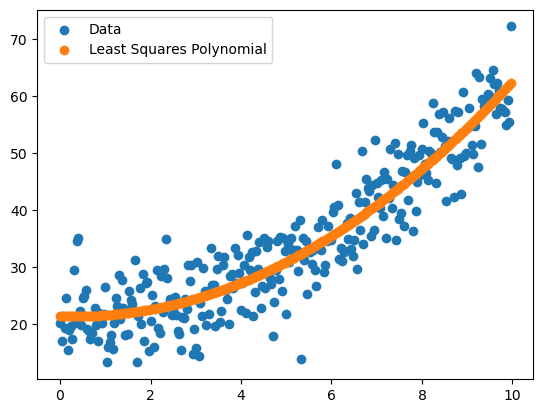

In [9]:
plt.scatter(xvec,data,label='Data')
plt.scatter(xvec,x[0]*xvec + x[1]*xvec**2 + x[2],label='Least Squares Polynomial')
plt.legend()
plt.show()

## Solving a Least Squares System (with a detour for conditioning)

The above worked quite nicely but so far we've worked purely with the numpy least squares solver, which makes life nice and easy for us.

Let's dive into how we really solve a system such as this through nuts and bolts linear algebra routines. 

As noted previously, we've been setting up our system using the least squares formulation:

$$Ax = B$$

where the goal is to minimise the "residuals" $||Ax - B||^2 $, where $||\:||^2$ is the eucliean 2-norm, such that:

$$||x||^2 = \sqrt{x_1^2 + x_2^2 + x_N^2 }$$

If we substitute in our system $Ax = B$ into this:

$$||Ax - B||^2 = (Ax - B)^T(Ax-B)$$

which when expanded out equals:

$$(Ax - B)^T(Ax-B) = x^TA^T A x - x^T A^T B - B^T A x + B^T B$$ 
where we can use $x^Ta^TB = B^TAx$ to simplify further, setting the whole quantity to minimise to $J$:

$$J = x^TA^T A x - 2x^T A^T B + B^T B$$

We want to minimise this residual, thus we want to reach a point where it no longer changes. We can do that by differentiating it and setting the resulting quantity to 0:

$$\frac{\partial J}{\partial x} = 2 A^T A x - 2 A^T B = 0$$

And then we can solve $2 A^T A x = 2 A^T B$ fairly easily:

$$A^T A x = A^T B \\
x = (A^T A)^{-1} A^T B $$

And there we have our least squares estimator. Now the problems that remain are:

1) How to invert $A^T A$ 
2) Conditioning of our system

Lets start with 1)

## Factorising Ax = B

Any matrix can be factorised into a product of other matrices. In our particular case we are interested in factorising $A^TA$. A is by definition not square, however $A^T A$ is a square matrix. There are several 
potential methods we could use, including the Cholesky Decomposition, LU Decomposition, or QR decomposition.

It's also worth pointing out that if $A$ is full rank then $A^T A$ is positive definite, which means we can use the very fast and efficient cholesky decomposition to factorize $(A^T A) = RR^T$, where $R$ is a triangular matrix.

This allows us to re-write our original equation as:

$RR^Tx = A^TB$

We can solve this by first factoring out $R^Tx$:

$$
\begin{align}
R^Tx = z \\
Rz = A^TB  
\end{align}
$$

As $R$ is is triangular, we can solve for $z$ first by forwards substitution from $Rz = A^TB$. We can then solve for $x$ by backwards substitution.

In [10]:
aat = numpy.dot(A.T,A)
uaat,saat,vhaat = numpy.linalg.svd(aat)

In [11]:
print("Condition Number:")
print(saat[0]/saat[-1])

Condition Number:
20931.675508131746


Not great, not terrible. If your condition number gets too high, you'll eventually be unable to solve the system depending on the floating point precision. 

Condition numbers greater than roughly $10^6$-$10^7$ will be unstable on single precision floating point arithmetic (`float`), and greater than $10^{12}$-$10^{14}$ will be unstable on double precision floating point arithmetic (`double`)

In [12]:
R = numpy.linalg.cholesky(aat)

In [13]:
CholRhs = numpy.dot(A.T,B)

In [14]:
print(R)

[[ 99.74996519   0.           0.        ]
 [746.87578277 192.84106463   0.        ]
 [ 14.9874739   -6.449486     5.81203548]]


In [15]:
coeffs_lt = scipy.linalg.solve_triangular(R,CholRhs,lower=True)
coeffs_ut = scipy.linalg.solve_triangular(R.T,coeffs_lt,lower=False)

In [16]:
print("Least Squares Parameters:")
print("m1 =",coeffs_ut[0])
print("m2 =",coeffs_ut[1])
print("c =",coeffs_ut[2])

Least Squares Parameters:
m1 = -0.31937855574261975
m2 = 0.4432801422306257
c = 21.40702000126996


## Alternative Factorization: QR Decomposition

We can also do this using the QR decomposition. The QR decomposition has the benefit of enhanced
stability over other decomposition methods and works for both square and non-square systems.

For stability:

QR > Cholesky > LU

For Speed:

Cholesky > LU > QR

LU decompositions can be great in practice however for parallelised systems which is why I mention it, such as on a cluster or GPU, due to the pleasantly parallelisable nature of the partial and complete pivoting schemes in this decomposition.

There are various other factorisations depending on the exact properties of the the system $A$ that you are trying to solve! 

### QR Algorithm

From above we have the least squares estimator:

$A^TAx = A^TB$

The QR factorization allows us to factor $A = QR$, where $Q$ is an orthogonal matrix and $R$ is an upper triangular matrix. Expanding out we get:

$R^T Q^T Q R x = R^T Q^T B$

As $Q$ is orthogonal $Q^T Q = I$ where $I$ is the identity matrix:

$R^T R x = R^T Q^T B \\
Rx = Q^T B$

After multiplying $Q^T$ with $B$ we can then solve easily using a simple backwards subsitution triangular solver (or more elaborate blocked scheme). 

In [17]:
u,s,vh = numpy.linalg.svd(A)

In [18]:
print("Condition Number: ")
print(s[0]/s[-1])

Condition Number: 
144.6778335065103


In [19]:
q,r = numpy.linalg.qr(A,mode='reduced')

In [20]:
rhs = numpy.dot(q.T,B)

In [21]:
coeffs = scipy.linalg.solve_triangular(r,rhs,lower=False)

In [22]:
print("Least Squares Parameters:")
print("m1 =",coeffs[0])
print("m2 =",coeffs[1])
print("c =",coeffs[2])

Least Squares Parameters:
m1 = -0.3193785557431874
m2 = 0.4432801422306797
c = 21.407020001271043


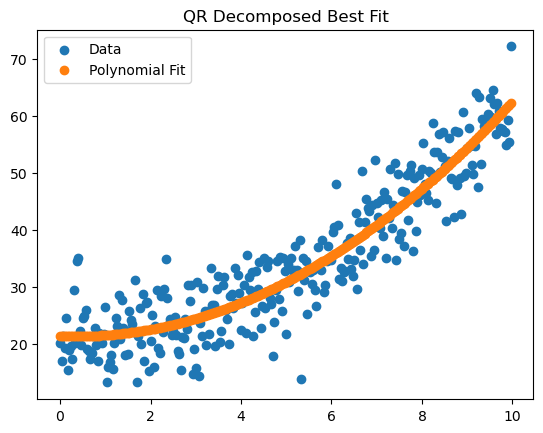

In [23]:
plt.title("QR Decomposed Best Fit")
plt.scatter(xvec,data,label='Data')
plt.scatter(xvec,coeffs[0]*xvec + coeffs[1]*xvec**2 + coeffs[2],label='Polynomial Fit')
plt.legend()
plt.show()

## Uncertainty 

In our least squares regression fits it would be nice to understand how the uncertainty our fit varies over the range bounded by our fit.

It is not always possible to know the uncertainty at each point, but by inspection we can be assured that the data points are sampled from some unknown distribution.

The challenging part is how to understand this uncertainty pertains to the fit of the individual regression parameters.

### Bootstrap Method

The bootstrap method is a classic statistical method for estimating properties of some random variable. In the particular case of linear regression we would like to understand the derived variables in our regression model.

We will continue to use our 2nd order polynomial model from above:
$$y = c + m_1x + m_2x^2$$

where we now view the variables as random variables, $c = C + \sigma_c$, $m_1 = M_1 \pm \sigma_{M_1}$, $m_2 = M_2 \pm \sigma_{M_2}$. Here each variable is modelled as a random variable with some mean value (capitalised), and a measure of uncertainty ($\sigma$) 

Warning: Here I am making an assumption that the variables can be modelled as gaussian (which is in fact true as the noise we impart is Gaussian).

In [24]:
RESAMPLE_ITERATIONS = 500

def bootstrap_linear_regressor(x_vector,data):
    stacked_data = numpy.vstack((x_vector,data)).T.copy()
    
    def resample_data(data):
        size = data.shape[0]
        new_data = numpy.zeros_like(data)
        
        for i in numpy.arange(size):
            idx = numpy.random.randint(0,size-1)
            new_data[i,...] = data[idx,...]
            
        return new_data
    
    def calculate_polynomial_best_fit(data):
        #print(data.shape)
        #print(data[:,1,numpy.newaxis].shape)
        #print(numpy.ones_like(data[:,1])[:,numpy.newaxis].shape)
        A = numpy.concatenate((data[:,0,numpy.newaxis],data[:,0,numpy.newaxis]**2,numpy.ones_like(data[:,0])[:,numpy.newaxis]),axis=1)
        B = data[:,1]
        
        q,r = numpy.linalg.qr(A,mode='reduced')
        rhs = numpy.dot(q.T,B)
        import scipy.linalg
        coeffs = scipy.linalg.solve_triangular(r,rhs,lower=False)
        
        return coeffs
    
    bootstrapped_coefficients = numpy.empty(shape=(RESAMPLE_ITERATIONS,3))
    
    for i in range(RESAMPLE_ITERATIONS):
        
        new_data = resample_data(stacked_data)
        bootstrapped_coefficients[i,...] = calculate_polynomial_best_fit(new_data)
        
    mean_coefficients = numpy.mean(bootstrapped_coefficients,axis=0)
    std_coefficients = numpy.std(bootstrapped_coefficients,axis=0)
        
    return mean_coefficients,std_coefficients

bs_mean, bs_std = bootstrap_linear_regressor(xvec,data)  

print("Average 0th Coefficient: ", bs_mean[0]," +/- ",bs_std[0])
print("Average 1st Coefficient: ", bs_mean[1]," +/- ",bs_std[1])
print("Average 2nd Coefficient: ", bs_mean[2]," +/- ",bs_std[2])

Average 0th Coefficient:  -0.23769987259418568  +/-  0.4093276461997083
Average 1st Coefficient:  0.4335802359074286  +/-  0.03862722155261405
Average 2nd Coefficient:  21.290712855960535  +/-  0.8855797779173232


Now let's plot the our regressor with parameters inclusive of the variance of said parameters.

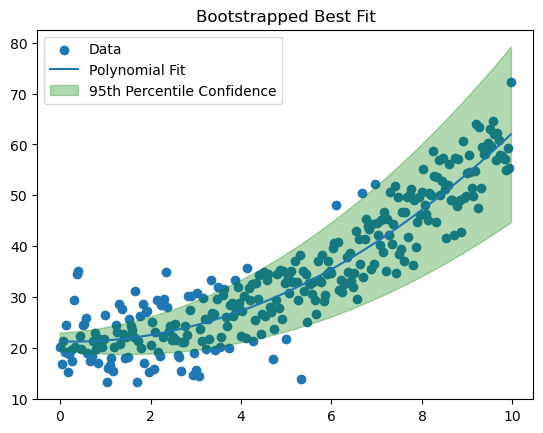

In [25]:
bs_std_95th_percentile = bs_std * 1.96

lower_bound = (bs_mean[0]-bs_std_95th_percentile[0])*xvec + (bs_mean[1]-bs_std_95th_percentile[1])*xvec**2 + (bs_mean[2]-bs_std_95th_percentile[2])
upper_bound = (bs_mean[0]+bs_std_95th_percentile[0])*xvec + (bs_mean[1]+bs_std_95th_percentile[1])*xvec**2 + (bs_mean[2]+bs_std_95th_percentile[2])

plt.title("Bootstrapped Best Fit")
plt.scatter(xvec,data,label='Data')
plt.plot(xvec,bs_mean[0]*xvec + bs_mean[1]*xvec**2 + bs_mean[2],label='Polynomial Fit')
plt.fill_between(xvec,lower_bound,upper_bound,color='green',alpha=0.3,label='95th Percentile Confidence')
plt.legend()
plt.show()

### Other Methods

The bootstrap method makes minimal assumptions about the underlying data distribution and is effective for a wide variety of different datasets.

If we have direct knowledge of the uncertainty of each data point, we could encode that directly when computing the polynomial coefficients.